In [1]:
import numpy as np
import pandas as pd
import pulp as lp
import pickle as pkl
import time
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import datetime as dt
import ALMplanner as ALM

In [2]:
######
EX = 1
######


if EX == 1:
    problem = ALM.ALMPlanner(start = "Jan 2021", end = "Jan 2041", user_risk_profile = 0)
    # set planned liabilities
    problem.liabilities.insert("car", "Jan 2026", 30000, 30000*0.65)
    problem.liabilities.insert("university", "Jan 2029", 50000, 50000*0.95)
    problem.liabilities.insert("hawaii", "Jan 2037",30000, 30000*0.85)
    # set planned assets 
    problem.assets.insert("ass_0","Jan 2021",30000)
    recurrent_dates = ["Jan 2022", "Jan 2023", "Jan 2024", "Jan 2025", "Jan 2026", "Jan 2027"]
    for i in np.arange(len(recurrent_dates)):
        problem.assets.insert("ass_" + str(i+1),recurrent_dates[i],10000)
elif EX == 2:
    problem = ALM.ALMPlanner(start = "Jan 2021", end = "Jan 2061")
    # set planned liabilities
    recurrent_assets = pd.date_range(start = "Jan 2021", end="Jan 2040", freq = pd.offsets.YearBegin(1))
    for i in np.arange(len(recurrent_assets)):
        problem.assets.insert("ass_" + str(i+1),recurrent_assets[i],1000)
    recurrent_liabilities = pd.date_range(start = "Jan 2041", end="Jan 2060", freq = pd.offsets.YearBegin(1))
    for i in np.arange(len(recurrent_liabilities)):
        problem.liabilities.insert("liab_" + str(i+1),recurrent_liabilities[i],1500,1100)

problem.display(bar_width = 6)

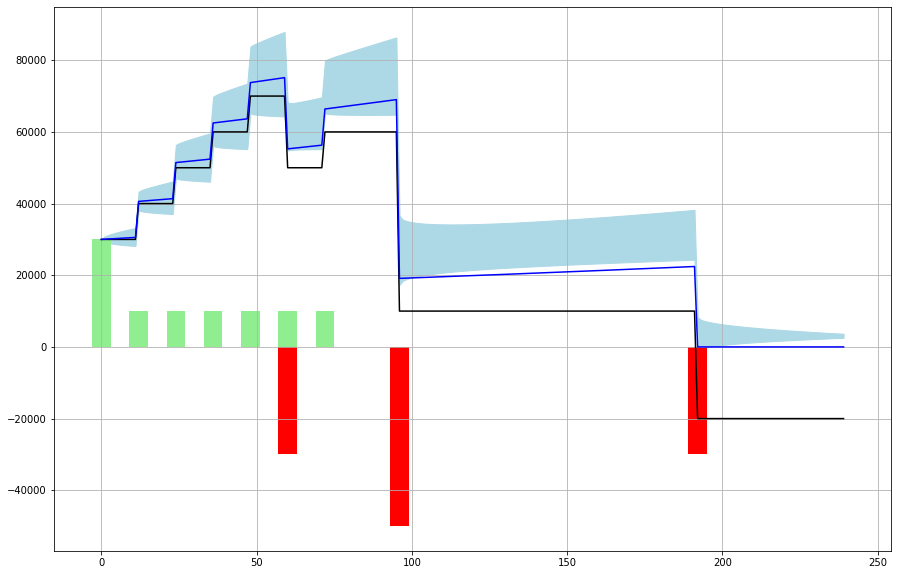

In [3]:
problem.display_old(bar_width = 6)

In [4]:
def smart_asset_allocation(Planner):
    Assets_list = Planner.assets.lists()
    Liabs_list = Planner.liabilities.lists()
    
    Lt = Liabs_list["Month since Start"]
    L = Liabs_list.index
    Liab_tg = Liabs_list["Target Liability"]
    Liab_lb = Liabs_list["Lowerbound Liability"]
    At = Assets_list["Month since Start"]
    A = Assets_list.index
    Assets = Assets_list["Asset Value"]

    asset_split = pd.DataFrame(0,columns = L, index = A)
    total_asset = Assets.sum()
    total_liab_lb = Liab_lb.sum()
    budget = {}
    
    for l in L:
        budget[l] = min(Liab_lb[l], Liab_lb[l]/total_liab_lb*total_asset)
    
    for a in A:
        L_feas = Lt[Lt>At[a]]
        for l in L_feas.index:
            asset_split[l][a] = min(max(Assets[a] - asset_split.loc[a,:].T.sum(),0), budget[l] - asset_split[l].sum())

    asset_end = Assets - asset_split.T.sum()
    return asset_split, asset_end

smart_asset_allocation(problem)


(         car  university  hawaii
 ass_0  18972       11028       0
 ass_1      0       10000       0
 ass_2      0       10000       0
 ass_3      0       10000       0
 ass_4      0        5188    4812
 ass_5      0           0   10000
 ass_6      0           0    9998,
 ass_0    0
 ass_1    0
 ass_2    0
 ass_3    0
 ass_4    0
 ass_5    0
 ass_6    2
 dtype: object)

In [5]:
problem.check_feasibility()
problem.get_feasibility()
problem.display(bar_width = 6)

check feasibility ended in 8.87 s with Optimal solution
Unfeasible problem: suggested +2.53%  on assets


In [6]:
problem.generate_model(model_version="V3")
problem.solve()

problem.generate_buyandhold()
problem.solve_BAH()

Model generated in 8.45 s
Solve ended in 2.56 s with Optimal solution
Buy-And-Hold generated in 7.48 s
Solve ended in 0.61 s with Optimal solution


# Display solution

In [7]:
P = problem.P
A = problem.assets.set
L = problem.liabilities.set
N = problem.N
T = problem.T
Scenario = problem.Scenario

In [8]:
#sol = problem.solution_BAH
sol = problem.solution


In [9]:
Assets_l = {}
Assets_end = {}
for a in A:
    Assets_l[a] = np.zeros(shape = (len(L), len(P)))
    Assets_end[a] = np.zeros(shape = (len(P)))
    for p in np.arange(len(P)):
        Assets_end[a][p] = sol.asset_end_part[a][P[p]]
        for l in np.arange(len(L)):
            Assets_l[a][l,p] = sol.asset_part[a][L[l]][P[p]]

In [10]:
def standardized_chart(plt):
    plt.update_layout(
        paper_bgcolor = "white",
        showlegend=True,
        plot_bgcolor="white",
        margin=dict(t=20,l=20,b=20,r=20)
    )
    plt.update_xaxes(showgrid=True, gridwidth=1, gridcolor='darkgray')
    plt.update_yaxes(showgrid=True, gridwidth=1, gridcolor='darkgray')
    plt.update_xaxes(showline=True, linewidth=1.3, linecolor='black', mirror = True)
    plt.update_yaxes(showline=True, linewidth=1.3, linecolor='black', mirror = True)
    return plt

In [11]:
#AssetPerETF
AssetPerETF = {}

for a in A:
    Asset_ap = np.sum(Assets_l[a], axis = 0) + Assets_end[a] 
    AssetPerETF[a] = {P[p]:Asset_ap[p] for p in np.arange(len(P))}

AssetPerETF = pd.DataFrame(AssetPerETF).transpose().reset_index()
AssetPerETF = AssetPerETF.melt(id_vars=['index'], var_name='P', value_name='split')
plt = px.bar(AssetPerETF, x="index", y = "split", color = "P" )
plt = standardized_chart(plt)
#AssetPerETF.plot.bar(stacked = True, figsize = (15,10))
plt.show()

In [12]:
AssetPerLiab = {}
for a in A:
    Asset_al = list(np.sum(Assets_l[a], axis = 1))
    Asset_al.append(np.sum(Assets_end[a]))
    L_end = list(L)
    L_end.append("end")
    AssetPerLiab[a] = {L_end[l]:Asset_al[l] for l in np.arange(len(L_end))}

AssetPerLiab = pd.DataFrame(AssetPerLiab).transpose().reset_index()
AssetPerLiab = AssetPerLiab.melt(id_vars=['index'], var_name='Liab', value_name='split')
plt = px.bar(AssetPerLiab, x="index", y = "split", color = "Liab")
plt = standardized_chart(plt)
plt.show()

In [ ]:
n_scen = 5
#print([solution[l][n_scen].varValue for l in Lt])
Q_nscen = np.zeros(shape = (len(P),len(L)))
Val_tl = {}
i = -1
At = sorted(list(problem.assets.period.values()))
label_period = [[k, v] for k,v in problem.assets.period.items()]
label_value = [[k, v] for k,v in problem.assets.value.items()]
period_value_df = pd.DataFrame(label_period, columns = ["Label", "Period"]).merge(pd.DataFrame(label_value, columns = ["Label", "Value"]))

for p in P:
    i = i+1
    Val_tl[p] = np.zeros(shape = (len(T), len(L)))
    for l in np.arange(len(L)):
        for t in np.arange(len(T)):
            if t < problem.liabilities.period[L[l]]:
                new_asset_label = period_value_df.loc[period_value_df.Period == t , "Label" ].values
                new_asset = [sol.asset_part[a][L[l]][p] for a in new_asset_label]
                if t==0:
                    Val_tl[p][t,l] = sum(new_asset)*np.exp(Scenario[p][n_scen][t])
                else:
                    Val_tl[p][t,l] = (Val_tl[p][t-1,l] + sum(new_asset))*np.exp(Scenario[p][n_scen][t])

            elif t == problem.liabilities.period[L[l]]:
                Q_nscen[i,l] = Val_tl[p][t-1,l]
    
Val_end_t = {}
for p in P:
    Val_end_t[p] = np.zeros(shape = (len(T)))
    for t in np.arange(len(T)):
        new_asset_label = period_value_df.loc[period_value_df.Period == t , "Label" ].values
        new_asset = [sol.asset_end_part[a][p] for a in new_asset_label]
        if t==0:
            Val_end_t[p][t] = sum(new_asset)*np.exp(Scenario[p][n_scen][t])
        else:
            Val_end_t[p][t] = (Val_end_t[p][t-1] + sum(new_asset))*np.exp(Scenario[p][n_scen][t])


Val_t = {}
for p in P:
    Val_t[p] = np.sum(Val_tl[p], axis = 1) + Val_end_t[p] 

AssetAllocationNominal = pd.DataFrame(Val_t)
AssetAllocationNominal[AssetAllocationNominal<0] = 0
AAN_perc = AssetAllocationNominal.divide(AssetAllocationNominal.sum(axis=1), axis=0)

AssetAllocationNominal = AssetAllocationNominal.reset_index()
AssetAllocationNominal = AssetAllocationNominal.melt(id_vars=['index'], var_name='P', value_name='evo')
plt = px.area(AssetAllocationNominal, x="index", y = "evo", color = "P" )
plt = standardized_chart(plt)
plt.show()

AAN_perc = AAN_perc.reset_index()
AAN_perc = AAN_perc.melt(id_vars=['index'], var_name='P', value_name='evo')
plt = px.area(AAN_perc, x="index", y = "evo", color = "P" )
plt.update_xaxes(range=[AAN_perc["index"].min(), AAN_perc["index"].max()])
plt.update_yaxes(range=[0, 1])
plt = standardized_chart(plt)
plt.show()

In [ ]:
Scenario_mu = problem.Scenario_mu
#print([solution[l][n_scen].varValue for l in Lt])
Q_nscen = np.zeros(shape = (len(P),len(L)))
Q_ex = np.zeros(shape = (len(P),len(L)))
Val_tl = {}
i = -1
At = sorted(list(problem.assets.period.values()))
label_period = [[k, v] for k,v in problem.assets.period.items()]
label_value = [[k, v] for k,v in problem.assets.value.items()]
period_value_df = pd.DataFrame(label_period, columns = ["Label", "Period"]).merge(pd.DataFrame(label_value, columns = ["Label", "Value"]))

for p in P:
    i = i+1
    Val_tl[p] = np.zeros(shape = (len(T), len(L)))
    for l in np.arange(len(L)):
        for t in np.arange(len(T)):
            if t < problem.liabilities.period[L[l]]:
                new_asset_label = period_value_df.loc[period_value_df.Period == t , "Label" ].values
                new_asset = [sol.asset_part[a][L[l]][p] for a in new_asset_label]
                if t==0:
                    Val_tl[p][t,l] = sum(new_asset)*np.exp(Scenario_mu[p])
                else:
                    Val_tl[p][t,l] = (Val_tl[p][t-1,l] + sum(new_asset))*np.exp(Scenario_mu[p])

            elif t == problem.liabilities.period[L[l]]:
                Q_ex[i,l] = user_portfolio[p]
                Q_nscen[i,l] = Val_tl[p][t-1,l]
    
Val_end_t = {}
for p in P:
    Val_end_t[p] = np.zeros(shape = (len(T)))
    for t in np.arange(len(T)):
        new_asset_label = period_value_df.loc[period_value_df.Period == t , "Label" ].values
        new_asset = [sol.asset_end_part[a][p] for a in new_asset_label]
        if t==0:
            Val_end_t[p][t] = sum(new_asset)*np.exp(Scenario_mu[p])
        else:
            Val_end_t[p][t] = (Val_end_t[p][t-1] + sum(new_asset))*np.exp(Scenario_mu[p])


Val_t = {}
for p in P:
    Val_t[p] = np.sum(Val_tl[p], axis = 1) + Val_end_t[p] 

AssetAllocationNominal = pd.DataFrame(Val_t)
AssetAllocationNominal[AssetAllocationNominal<0] = 0
AAN_perc = AssetAllocationNominal.divide(AssetAllocationNominal.sum(axis=1), axis=0)

AssetAllocationNominal = AssetAllocationNominal.reset_index()
AssetAllocationNominal = AssetAllocationNominal.melt(id_vars=['index'], var_name='P', value_name='evo')
plt = px.area(AssetAllocationNominal, x="index", y = "evo", color = "P")
plt = standardized_chart(plt)
plt.show()

AAN_perc = AAN_perc.reset_index()
AAN_perc = AAN_perc.melt(id_vars=['index'], var_name='P', value_name='evo')
plt = px.area(AAN_perc, x="index", y = "evo", color = "P" )
plt.update_xaxes(range=[AAN_perc["index"].min(), AAN_perc["index"].max()])
plt.update_yaxes(range=[0, 1])
plt = standardized_chart(plt)
plt.show()

In [10]:
Q_ln = {}
for l in L:
    Q_ln[l] = np.zeros(shape = (len(N)))
    for n in N:
        Q_ln[l][n]=sol.liab_distr[l][N[n]]

Q_ln["end"] = np.zeros(shape = (len(N)))
for n in N:
    Q_ln["end"][n]=sol.liab_end_distr[N[n]]

for l in L:
    affordable_short = Q_ln[l] < problem.liabilities.value_tg[l]
    cvar_prob = Q_ln[l] < np.quantile(Q_ln[l],1-problem.liabilities.cvar_lim[l])
    print(1-problem.liabilities.cvar_lim[l])
    print(np.mean(cvar_prob))
    print(l,":", problem.liabilities.value_tg[l], ", LB:", problem.liabilities.value_lb[l], ", Solution Cvar:", np.round(np.mean(Q_ln[l][Q_ln[l] <= np.quantile(Q_ln[l],1-problem.liabilities.cvar_lim[l])]),2), ", min: ", np.min(Q_ln[l]))


0.050000000000000044
0.046
car : 30000 , LB: 19500.0 , Solution Cvar: 19502.62 , min:  19461.2
0.050000000000000044
0.044
university : 50000 , LB: 47500.0 , Solution Cvar: 47507.32 , min:  47172.462
0.050000000000000044
0.045
hawaii : 30000 , LB: 25500.0 , Solution Cvar: 25592.95 , min:  20574.885


In [9]:
Q_ln = {}
Q_ex_ln = {}
for l in L:
    Q_ln[l] = np.zeros(shape = (len(N)))
    Q_ex_ln[l] = np.zeros(shape = (len(N)))
    for n in N:
        Q_ln[l][n]=sol.liab_distr[l][N[n]]
        Q_ex_ln[l][n]=sol.ex_wealth[l][N[n]]

#Q_ln["end"] = np.zeros(shape = (len(N)))
#for n in N:
#    Q_ln["end"][n]=sol.liab_end_distr[N[n]]
df_Q_ln = pd.DataFrame(Q_ln)
df_Q_ex_ln = pd.DataFrame(Q_ex_ln)
for l in L:
    print(df_Q_ex_ln.loc[df_Q_ln[l] < df_Q_ln[l].max(), l].describe())

count    999.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: car, dtype: float64
count    999.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: university, dtype: float64
count    145.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: hawaii, dtype: float64
